In [1]:
import sys
sys.path.append('/home/jovyan/QNN4RadarImage/')

In [3]:
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Activation, Flatten, MaxPool2D, BatchNormalization, AveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD

# Lenet-5

In [4]:
kernel_size = 3
stride = 1

lenet_5_model = Sequential()
lenet_5_model.add(Conv2D(16, kernel_size=kernel_size, strides=stride, activation='relu', padding='same', input_shape = (64,64,3)))
lenet_5_model.add(AveragePooling2D())
lenet_5_model.add(Conv2D(32, kernel_size=kernel_size, strides=stride, activation='relu', padding='valid'))
lenet_5_model.add(AveragePooling2D())
lenet_5_model.add(Conv2D(64, kernel_size=kernel_size, strides=stride, activation='relu', padding='valid'))
lenet_5_model.add(AveragePooling2D())

lenet_5_model.add(Flatten())
lenet_5_model.add(Dense(8, activation='relu'))
lenet_5_model.add(Dense(16, activation='relu'))
lenet_5_model.add(Dense(10, activation='softmax'))

lenet_5_model.compile(optimizer=SGD(lr=0.0002), loss='categorical_crossentropy', metrics=['accuracy'])
lenet_5_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 16)        448       
                                                                 
 average_pooling2d (AverageP  (None, 32, 32, 16)       0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        4640      
                                                                 
 average_pooling2d_1 (Averag  (None, 15, 15, 32)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 average_pooling2d_2 (Averag  (None, 6, 6, 64)         0

/opt/conda/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


# Load Dataset

In [5]:
from DatasetHandler import DatasetHandler

dataset_root = '/home/jovyan/QNN4RadarImage/datasets/EuroSAT/'
handler = DatasetHandler(dataset_root)

In [6]:
classes = []
for i, c in enumerate(handler.classes):
  cl = c.split('/')[-1]
  classes.append(cl)
  print('Class %d -> %s' % (i, cl))

Class 0 -> Residential
Class 1 -> PermanentCrop
Class 2 -> Industrial
Class 3 -> AnnualCrop
Class 4 -> Highway
Class 5 -> Forest
Class 6 -> Pasture
Class 7 -> SeaLake
Class 8 -> HerbaceousVegetation
Class 9 -> River


In [7]:
imgs_path, imgs_label = handler.load_paths_labels(dataset_root, classes=classes)
print('Dataset images:', len(imgs_path), 'Dataset labels:', len(imgs_label))
print('Dataset sample ->', imgs_path[0], imgs_label[0])

Dataset images: 27000 Dataset labels: 27000
Dataset sample -> /home/jovyan/QNN4RadarImage/datasets/EuroSAT/Pasture/Pasture_636.jpg 5


In [8]:
train_imgs, train_labels, val_images, val_labels = handler.train_validation_split(imgs_path, imgs_label, split_factor=0.2)
print('X_train shape:', train_imgs.shape, 'Y_train shape:', train_labels.shape)
print('  X_val shape: ', val_images.shape, '  Y_val shape: ', val_labels.shape)

X_train shape: (21600,) Y_train shape: (21600,)
  X_val shape:  (5400,)   Y_val shape:  (5400,)


In [10]:
batch_size = 1
epochs = 100

train_gen = handler.cnn_data_loader(train_imgs, train_labels, batch_size=batch_size, img_shape=(64,64,3), n_classes=10)
val_gen = handler.cnn_data_loader(val_images, val_labels, batch_size=batch_size, img_shape=(64,64,3), n_classes=10)


es = EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=0, mode='auto', baseline=None, restore_best_weights=False)

history = lenet_5_model.fit(train_gen,
                            steps_per_epoch = len(train_labels)//batch_size,
                            epochs = epochs,
                            validation_data = val_gen,
                            validation_steps = len(val_labels)//batch_size,
                            callbacks = [es])

Epoch 1/100
21600/21600 [==============================] - 97s 4ms/step - loss: 2.2458 - accuracy: 0.1716 - val_loss: 2.1708 - val_accuracy: 0.2163
Epoch 2/100
21600/21600 [==============================] - 98s 5ms/step - loss: 2.0453 - accuracy: 0.2460 - val_loss: 1.9550 - val_accuracy: 0.2720
Epoch 3/100
21600/21600 [==============================] - 100s 5ms/step - loss: 1.8209 - accuracy: 0.2994 - val_loss: 1.7853 - val_accuracy: 0.3167
Epoch 4/100
21600/21600 [==============================] - 98s 5ms/step - loss: 1.6971 - accuracy: 0.3420 - val_loss: 1.6161 - val_accuracy: 0.4002
Epoch 5/100
21600/21600 [==============================] - 101s 5ms/step - loss: 1.6036 - accuracy: 0.3862 - val_loss: 1.5729 - val_accuracy: 0.4117
Epoch 6/100
21600/21600 [==============================] - 101s 5ms/step - loss: 1.5562 - accuracy: 0.4056 - val_loss: 1.5072 - val_accuracy: 0.4274
Epoch 7/100
21600/21600 [==============================] - 100s 5ms/step - loss: 1.5029 - accuracy: 0.4356 - 

In [11]:
lenet_5_model.save('/home/jovyan/QNN4RadarImage/JSTARS2021/classical_classifiers/saved_models_new/lenet5.h5')

In [16]:
import numpy as np
val_gen = iter(handler.cnn_data_loader(val_images, val_labels, batch_size=batch_size, img_shape=(64,64,3), n_classes=10))


predictions = []
targets = []

count = 0

for ct in range(len(val_images)):
    
    count = count + 1
    if count % 100 == 0:
        print('Predicting validation images: ' + str(count) + ' / ' + str(val_images.shape[0]))
    
    data, target = next(val_gen)
    output = lenet_5_model.predict(data, verbose = 0)
    
    predictions.append(np.argmax(output))
    targets.append(np.argmax(target))
  

Predicting validation images: 100 / 5400
Predicting validation images: 200 / 5400
Predicting validation images: 300 / 5400
Predicting validation images: 400 / 5400
Predicting validation images: 500 / 5400
Predicting validation images: 600 / 5400
Predicting validation images: 700 / 5400
Predicting validation images: 800 / 5400
Predicting validation images: 900 / 5400
Predicting validation images: 1000 / 5400
Predicting validation images: 1100 / 5400
Predicting validation images: 1200 / 5400
Predicting validation images: 1300 / 5400
Predicting validation images: 1400 / 5400
Predicting validation images: 1500 / 5400
Predicting validation images: 1600 / 5400
Predicting validation images: 1700 / 5400
Predicting validation images: 1800 / 5400
Predicting validation images: 1900 / 5400
Predicting validation images: 2000 / 5400
Predicting validation images: 2100 / 5400
Predicting validation images: 2200 / 5400
Predicting validation images: 2300 / 5400
Predicting validation images: 2400 / 5400
P

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
cm = confusion_matrix(predictions, targets, normalize='true')

S2
Accuracy: [0.73668189 0.97079038 0.8593482  0.74768519 0.85658915 0.79217604
 0.69142857 0.98792757 0.7398524  0.85996956] mean:  0.8242448929880949
                      precision    recall  f1-score   support

         Residential     0.7367    0.9081    0.8134       533
       PermanentCrop     0.9708    0.8954    0.9316       631
          Industrial     0.8593    0.7927    0.8247       632
          AnnualCrop     0.7477    0.6296    0.6836       513
             Highway     0.8566    0.9345    0.8938       473
              Forest     0.7922    0.7714    0.7817       420
             Pasture     0.6914    0.7378    0.7139       492
             SeaLake     0.9879    0.7781    0.8706       631
HerbaceousVegetation     0.7399    0.7909    0.7645       507
               River     0.8600    0.9947    0.9224       568

            accuracy                         0.8257      5400
           macro avg     0.8242    0.8233    0.8200      5400
        weighted avg     0.8328    0.825

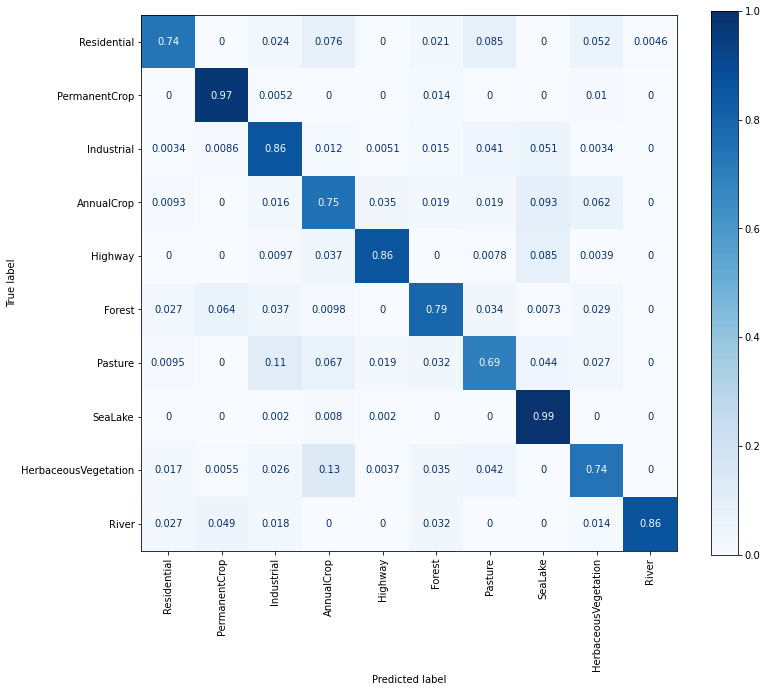

In [18]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (12,10))

cmd = ConfusionMatrixDisplay(cm, display_labels=classes)
cmd.plot(ax=axes, cmap='Blues', xticks_rotation='vertical')
print('S2')
print('Accuracy:', cm.diagonal(), 'mean: ', cm.diagonal().mean())
print(classification_report(targets, predictions, target_names=classes, digits=4))
axes.get_images()[0].set_clim(0, 1)
plt.show()
plt.close()

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np

In [20]:
cm = np.array([[76.0, 13.0],[11.0, 60.0]])
cm2 = np.array([[0.85, 0.15],[0.15, 0.85]])

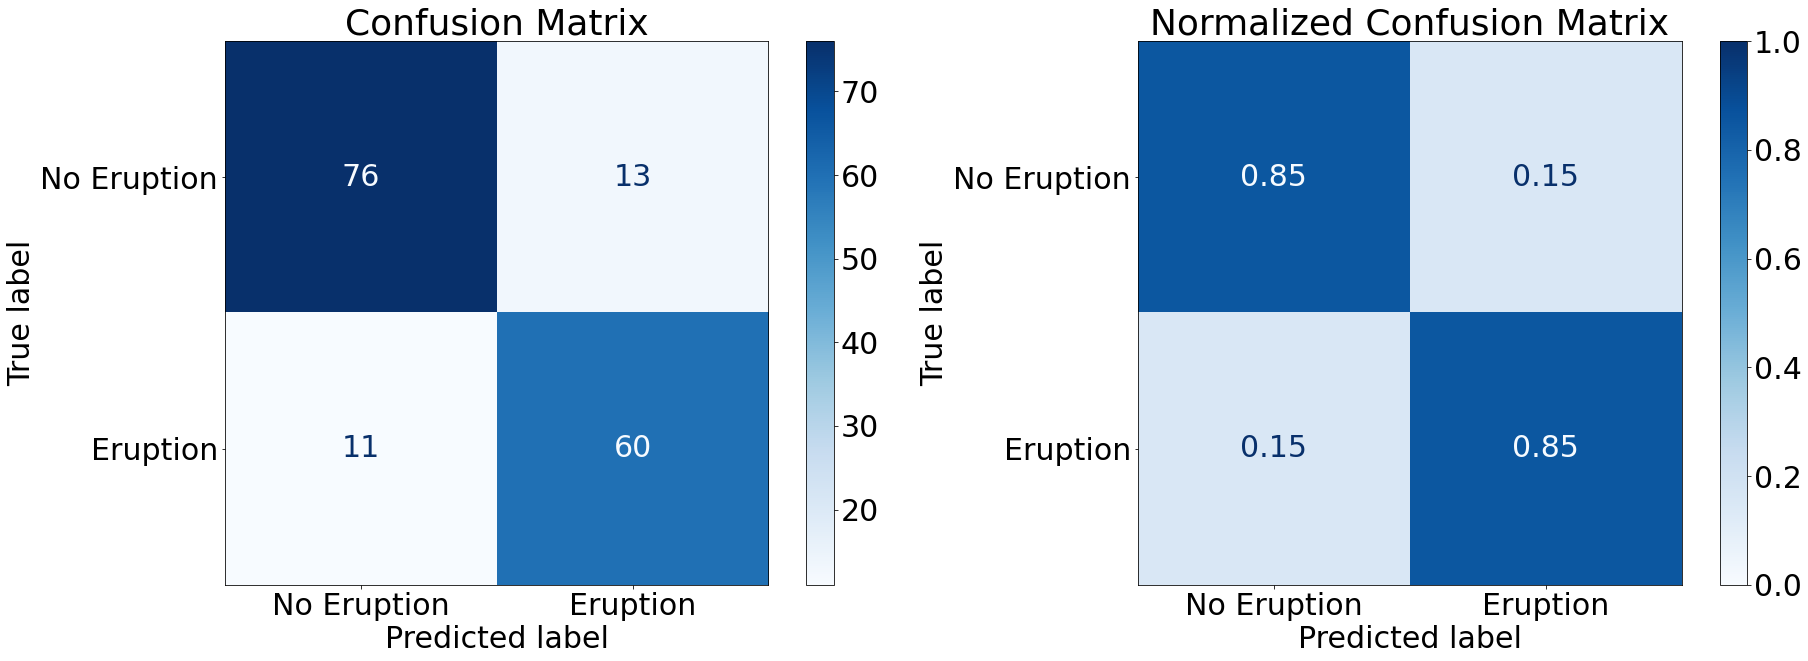

In [21]:
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 30})

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (30,10))

cmd = ConfusionMatrixDisplay(cm, display_labels=['No Eruption', 'Eruption'])
cmd.plot(ax=axes[0], cmap='Blues', xticks_rotation='horizontal')
#axes[0].get_images()[0].set_clim(0, 1)
axes[0].set_title('Confusion Matrix')

cmd = ConfusionMatrixDisplay(cm2, display_labels=['No Eruption', 'Eruption'])
cmd.plot(ax=axes[1], cmap='Blues', xticks_rotation='horizontal')
axes[1].get_images()[0].set_clim(0, 1)
axes[1].set_title('Normalized Confusion Matrix')
plt.show()
plt.close()

In [22]:
cm = np.array([[146, 67],[22, 51]]).astype(np.uint16)
cm2 = np.array([[0.690, 0.31],[0.30, 0.70]])

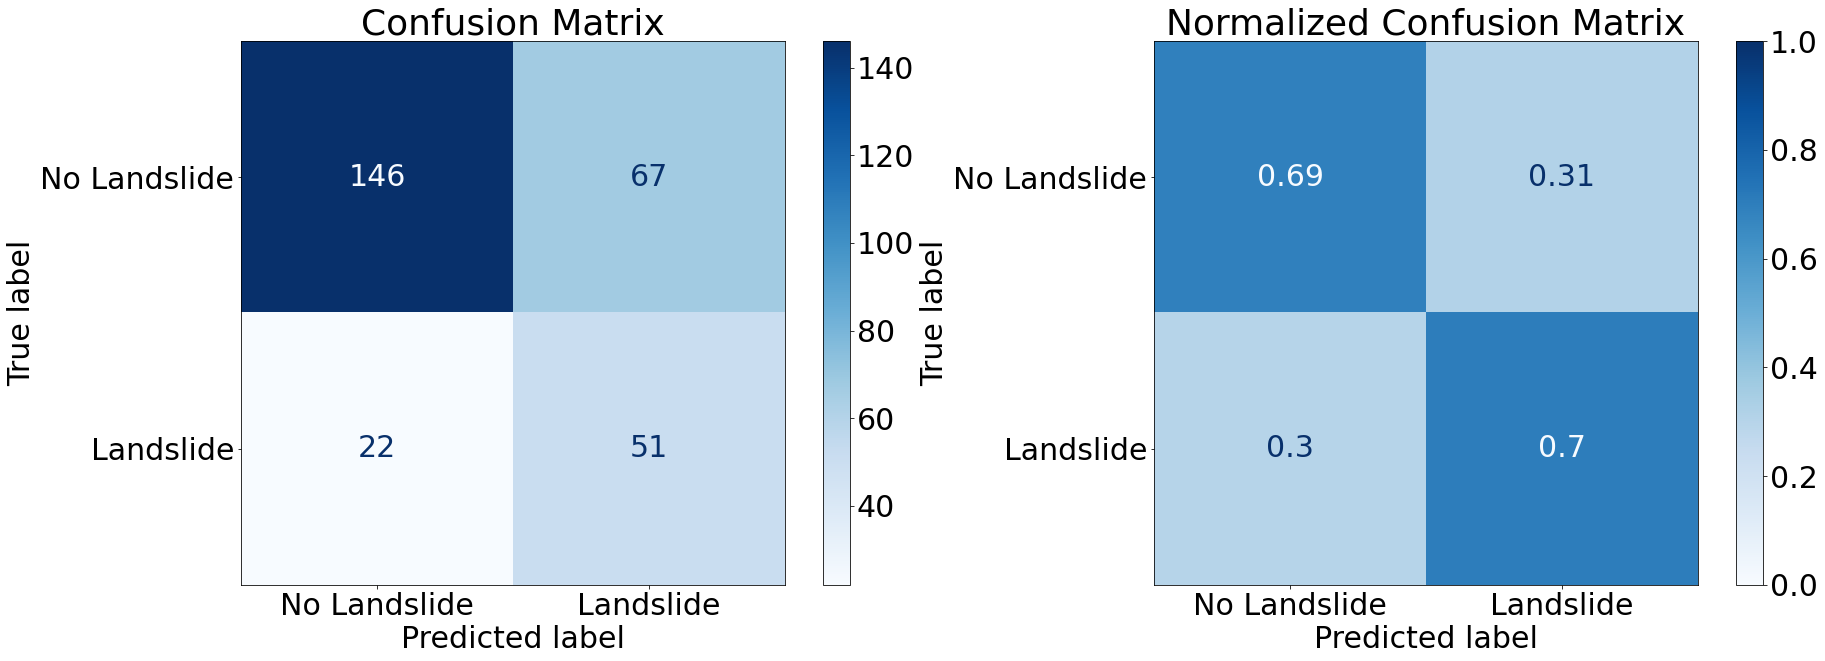

In [23]:
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 30})

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (30,10))
cmd = ConfusionMatrixDisplay(cm, display_labels=['No Landslide', 'Landslide'])
cmd.plot(ax=axes[0], cmap='Blues', xticks_rotation='horizontal', values_format = '')
#axes[0].get_images()[0].set_clim(0, 1)
axes[0].set_title('Confusion Matrix')


cmd = ConfusionMatrixDisplay(cm2, display_labels=['No Landslide', 'Landslide'])
cmd.plot(ax=axes[1], cmap='Blues', xticks_rotation='horizontal')
axes[1].get_images()[0].set_clim(0, 1)
axes[1].set_title('Normalized Confusion Matrix')
plt.show()
plt.close()


In [24]:
cmd.plot?

Signature:
cmd.plot(
    *,
    include_values=True,
    cmap='viridis',
    xticks_rotation='horizontal',
    values_format=None,
    ax=None,
    colorbar=True,
)
Docstring:
Plot visualization.

Parameters
----------
include_values : bool, default=True
    Includes values in confusion matrix.

cmap : str or matplotlib Colormap, default='viridis'
    Colormap recognized by matplotlib.

xticks_rotation : {'vertical', 'horizontal'} or float,                          default='horizontal'
    Rotation of xtick labels.

values_format : str, default=None
    Format specification for values in confusion matrix. If `None`,
    the format specification is 'd' or '.2g' whichever is shorter.

ax : matplotlib axes, default=None
    Axes object to plot on. If `None`, a new figure and axes is
    created.

colorbar : bool, default=True
    Whether or not to add a colorbar to the plot.

Returns
-------
display : :class:`~sklearn.metrics.ConfusionMatrixDisplay`
File:      /opt/conda/lib/python3.8/sit